In [ ]:
from PyMacroFin.model import macro_model
import numpy as np
import pandas as pd
import time
import PyMacroFin.utilities as util

def define_model():
    m = macro_model(name='BruSan')

    m.set_endog(['q','psi','mue','sigqk','sigqs'],init=[1,0.95,0,0,0],
        latex=[r'$q$',r'$\psi$',r'$\mu^{\eta}$',
            r'$\sigma^{q,k}$',r'$\sigma^{q,\sigma}$'])
    m.prices = ['q']
    m.set_state(['e','z'])
    m.set_value(['vi','vh'],init=[0.04,0.04],latex=[r'$\xi^i$',r'$\xi^h$'])

    m.params.add_parameter('gammai',2)
    m.params.add_parameter('gammah',3)
    m.params.add_parameter('ai',.1)
    m.params.add_parameter('ah',.1)
    m.params.add_parameter('rhoi',.04)
    m.params.add_parameter('rhoh',.04)
    m.params.add_parameter('sigz',.01)
    m.params.add_parameter('sigbar',.5)
    m.params.add_parameter('deltai',.04)
    m.params.add_parameter('deltah',.04)
    m.params.add_parameter('kappa_p',2)
    m.params.add_parameter('kappa_z',5)
    m.params.add_parameter('zetai',1.15)
    m.params.add_parameter('zetah',1.15)
    m.params.add_parameter('kappa_l',.9)
    m.params.add_parameter('ebar',0.5)

    m.equation("sigma = z")
    m.equation("wi = psi/e")
    m.equation("wh = (1-psi)/(1-e)")
    m.equation("ci = vi**((1-zetai)/(1-gammai))")
    m.equation("ch = vh**((1-zetah)/(1-gammah))")
    m.equation("iotai = (q-1)/kappa_p")
    m.equation("iotah = (q-1)/kappa_p")
    m.equation("phii = log(1+kappa_p*iotai)/kappa_p-deltai")
    m.equation("phih = log(1+kappa_p*iotah)/kappa_p-deltah")
    m.equation("muz = kappa_z*(sigbar-sigma)")
    m.equation("muk = psi*phii+(1-psi)*phih")
    m.equation("signis = wi*sigqs")
    m.equation("signhs = wh*sigqs")
    m.equation("signik = wi*(sigqk+sigma)")
    m.equation("signhk = wh*(sigqk+sigma)")
    m.equation("siges = e*(1-e)*(signis -sigqs)")
    m.equation("sigek = e*(1-e)*(signik - (sigqk+sigma))")
    m.equation("sigxik = d(vi,e)/vi*sigek*e")
    m.equation("sigxhk = d(vh,e)/vh*sigek*e")
    m.equation("sigxis = d(vi,e)/vi*siges*e + d(vi,z)/vi*sigz*z")
    m.equation("sigxhs = d(vh,e)/vh*siges*e + d(vh,z)/vh*sigz*z")
    m.equation("muq = d(q,e)/q*mue*e + d(q,z)/q*muz*z + \
                1/2*d(q,e,e)/q*((siges*e)**2 + (sigek*e)**2) + \
                1/2*d(q,z,z)/q*(sigz*z)**2 + d(q,e,z)/q*siges*e*sigz*z")
    m.equation("muri = (ai-iotai)/q + phii + muq + sigma*sigqk")
    m.equation("murh = (ah-iotah)/q + phih + muq + sigma*sigqk")
    m.equation("r = muri - gammai*wi*((sigqs**2)+(sigma+sigqk)**2) + \
                sigqs*sigxis + (sigqk+sigma)*sigxik")
    m.equation("muni = r + wi*(muri-r)-ci")
    m.equation("munh = r + wh*(murh-r)-ch")

    m.endog_equation("kappa_l/e*(ebar-e)+(1-e)*(muni - muk - muq\
                        - sigma*sigqk + (sigqk+sigma)**2 + sigqs**2 \
                        - wi*sigqs**2 - wi*(sigqk+sigma)**2) - mue")
    m.endog_equation("(ci*e+ch*(1-e))*q - psi*(ai-iotai) - (1-psi)*(ah-iotah)")
    m.endog_equation("muri - murh + gammah*wh*((sigqs**2)+(sigqk+sigma)**2) - \
                        gammai*wi*((sigqs)**2+(sigqk+sigma)**2) + sigqs*sigxis + \
                        (sigqk+sigma)*sigxik - sigqs*sigxhs - (sigqk+sigma)*sigxhk")
    m.endog_equation("(sigz*z*d(q,z) + siges*e*d(q,e))-sigqs*q")
    m.endog_equation("sigek*e*d(q,e) - sigqk*q")

    # m.hjb_equation('mu','e','mue*e')
    # m.hjb_equation('mu','z','muz*z')
    # m.hjb_equation('sig','e',"(siges*e)**2 + (sigek*e)**2")
    # m.hjb_equation('sig','z',"(sigz*z)**2")
    # m.hjb_equation('sig','cross',"siges*e*sigz*z")
    # m.hjb_equation('u','vi',0)
    # m.hjb_equation('u','vh',0)
    # m.hjb_equation('r','vi',"-1*(1-gammai)*(1/(1-1/zetai)*(ci-(rhoi+kappa_l))\
    #                 +r-ci+gammai/2*(wi*(sigqs)**2 +wi*(sigqk+sigma)**2))")
    # m.hjb_equation('r','vh',"-1*(1-gammah)*(1/(1-1/zetah)*(ch-(rhoh+kappa_l))\
    #                 +r-ch+gammah/2*(wh*(sigqs)**2 +wh*(sigqk+sigma)**2))")

    m.options.loop = False
    m.options.ignore_HJB_loop = True
    m.options.inner_plot = False
    m.options.outer_plot = False
    m.options.final_plot = True
    m.options.n0 = 50
    m.options.n1 = 50
    m.options.start0 = 0.05
    m.options.start1 = 0.05
    m.options.end0 = 0.95
    m.options.end1 = 0.95
    m.options.inner_solver = 'newton-raphson'
    m.options.parallel = True
    m.options.return_solution = True
    m.options.save_solution = False

    return m

tic = time.time()
m = define_model()
util.deploy_dash(m)
df = m.run()
toc = time.time()
print('elapsed time: {}'.format(toc-tic))

![result_plot](./pymacrofinsol2d.png)

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, Comparator, Constraint, EndogVar, EndogVarConditions, EndogEquation, System

In [3]:
pde_model = PDEModel("BruSan")
pde_model.set_state(["e", "z"], {"e": [0., 1.], "z": [0., 1.]})
pde_model.add_endogs(["q", "psi", "mue", "sigqk", "sigqs"], configs={
    "q": {"positive": True},
    "psi": {"positive": True},
    "mue": {"positive": True},
    "sigqk": {"positive": True},
    "sigqs": {"positive": True},
})
pde_model.add_agents(["vi", "vh"], configs={
    "vi": {"positive": True},
    "vh": {"positive": True},
})
pde_model.add_params({
    "gammai": 2,
    "gammah": 3,
    "ai": .1,
    "ah": .1,
    "rhoi": .04,
    "rhoh": .04,
    "sigz": .01,
    "sigbar": .5,
    "deltai": .04,
    "deltah": .04,
    "kappa_p": 2,
    "kappa_z": 5,
    "zetai": 1.15,
    "zetah": 1.15,
    "kappa_l": .9,
    "ebar": .5,
})

pde_model.add_equation("sigma = z")
pde_model.add_equation("wi = psi/e")
pde_model.add_equation("wh = (1-psi)/(1-e)")
pde_model.add_equation("ci = vi**((1-zetai)/(1-gammai))")
pde_model.add_equation("ch = vh**((1-zetah)/(1-gammah))")
pde_model.add_equation("iotai = (q-1)/kappa_p")
pde_model.add_equation("iotah = (q-1)/kappa_p")
pde_model.add_equation("phii = log(1+kappa_p*iotai)/kappa_p-deltai")
pde_model.add_equation("phih = log(1+kappa_p*iotah)/kappa_p-deltah")
pde_model.add_equation("muz = kappa_z*(sigbar-sigma)")
pde_model.add_equation("muk = psi*phii+(1-psi)*phih")
pde_model.add_equation("signis = wi*sigqs")
pde_model.add_equation("signhs = wh*sigqs")
pde_model.add_equation("signik = wi*(sigqk+sigma)")
pde_model.add_equation("signhk = wh*(sigqk+sigma)")
pde_model.add_equation("siges = e*(1-e)*(signis -sigqs)")
pde_model.add_equation("sigek = e*(1-e)*(signik - (sigqk+sigma))")
pde_model.add_equation("sigxik = vi_e/vi*sigek*e")
pde_model.add_equation("sigxhk = vh_e/vh*sigek*e")
pde_model.add_equation("sigxis = vi_e/vi*siges*e + vi_z/vi*sigz*z")
pde_model.add_equation("sigxhs = vh_e/vh*siges*e + vh_z/vh*sigz*z")
pde_model.add_equation("muq = q_e/q*mue*e + q_z/q*muz*z + 1/2*q_ee/q*((siges*e)**2 + (sigek*e)**2) + 1/2*q_zz/q*(sigz*z)**2 + q_ez/q*siges*e*sigz*z")
pde_model.add_equation("muri = (ai-iotai)/q + phii + muq + sigma*sigqk")
pde_model.add_equation("murh = (ah-iotah)/q + phih + muq + sigma*sigqk")
pde_model.add_equation("r = muri - gammai*wi*((sigqs**2)+(sigma+sigqk)**2) + sigqs*sigxis + (sigqk+sigma)*sigxik")
pde_model.add_equation("muni = r + wi*(muri-r)-ci")
pde_model.add_equation("munh = r + wh*(murh-r)-ch")

pde_model.add_endog_equation("kappa_l/e*(ebar-e)+(1-e)*(muni - muk - muq\
                     - sigma*sigqk + (sigqk+sigma)**2 + sigqs**2 \
                     - wi*sigqs**2 - wi*(sigqk+sigma)**2) - mue=0")
pde_model.add_endog_equation("(ci*e+ch*(1-e))*q - psi*(ai-iotai) - (1-psi)*(ah-iotah)=0")
pde_model.add_endog_equation("muri - murh + gammah*wh*((sigqs**2)+(sigqk+sigma)**2) - \
                     gammai*wi*((sigqs)**2+(sigqk+sigma)**2) + sigqs*sigxis + \
                     (sigqk+sigma)*sigxik - sigqs*sigxhs - (sigqk+sigma)*sigxhk=0")
pde_model.add_endog_equation("(sigz*z*q_z + siges*e*q_e)-sigqs*q=0")
pde_model.add_endog_equation("sigek*e*q_e - sigqk*q=0")

print(pde_model)
if not os.path.exists("./models/pymacrofin_2d.pt"):
    pde_model.train_model("./models", "pymacrofin_2d.pt", True)
    pde_model.eval_model(True)
else:
    pde_model.load_model(torch.load("./models/pymacrofin_2d.pt"))
    pde_model.eval_model(True)

============================Summary of Model BruSan=============================
Config: {
 "batch_size": 100,
 "num_epochs": 1000,
 "lr": 0.001
}
Latex Variable Mapping:
{}
User Defined Parameters:
{
 "gammai": 2,
 "gammah": 3,
 "ai": 0.1,
 "ah": 0.1,
 "rhoi": 0.04,
 "rhoh": 0.04,
 "sigz": 0.01,
 "sigbar": 0.5,
 "deltai": 0.04,
 "deltah": 0.04,
 "kappa_p": 2,
 "kappa_z": 5,
 "zetai": 1.15,
 "zetah": 1.15,
 "kappa_l": 0.9,
 "ebar": 0.5
}

================================State Variables=================================
e: [0.0, 1.0]
z: [0.0, 1.0]

=====================================Agents=====================================
Agent Name: vi
Agent(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=30, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=30, out_features=30, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=30, out_features=30, bias=True)
    (activation_2): Tanh()
    (linear_3): Linear(in_features=30, o

Total loss: 205186.9062: 100%|██████████| 1000/1000 [01:15<00:00, 13.30it/s]      


training finished, total time :: 75.18816184997559
Model saved to ./models/pymacrofin_2d.pt
===================================Evaluating===================================
loss :: endogeq_1: 41.6720,
endogeq_2: 2.6626,
endogeq_3: 627.4247,
endogeq_4: 0.0815,
endogeq_5: 0.0738,
total_loss: 671.9147


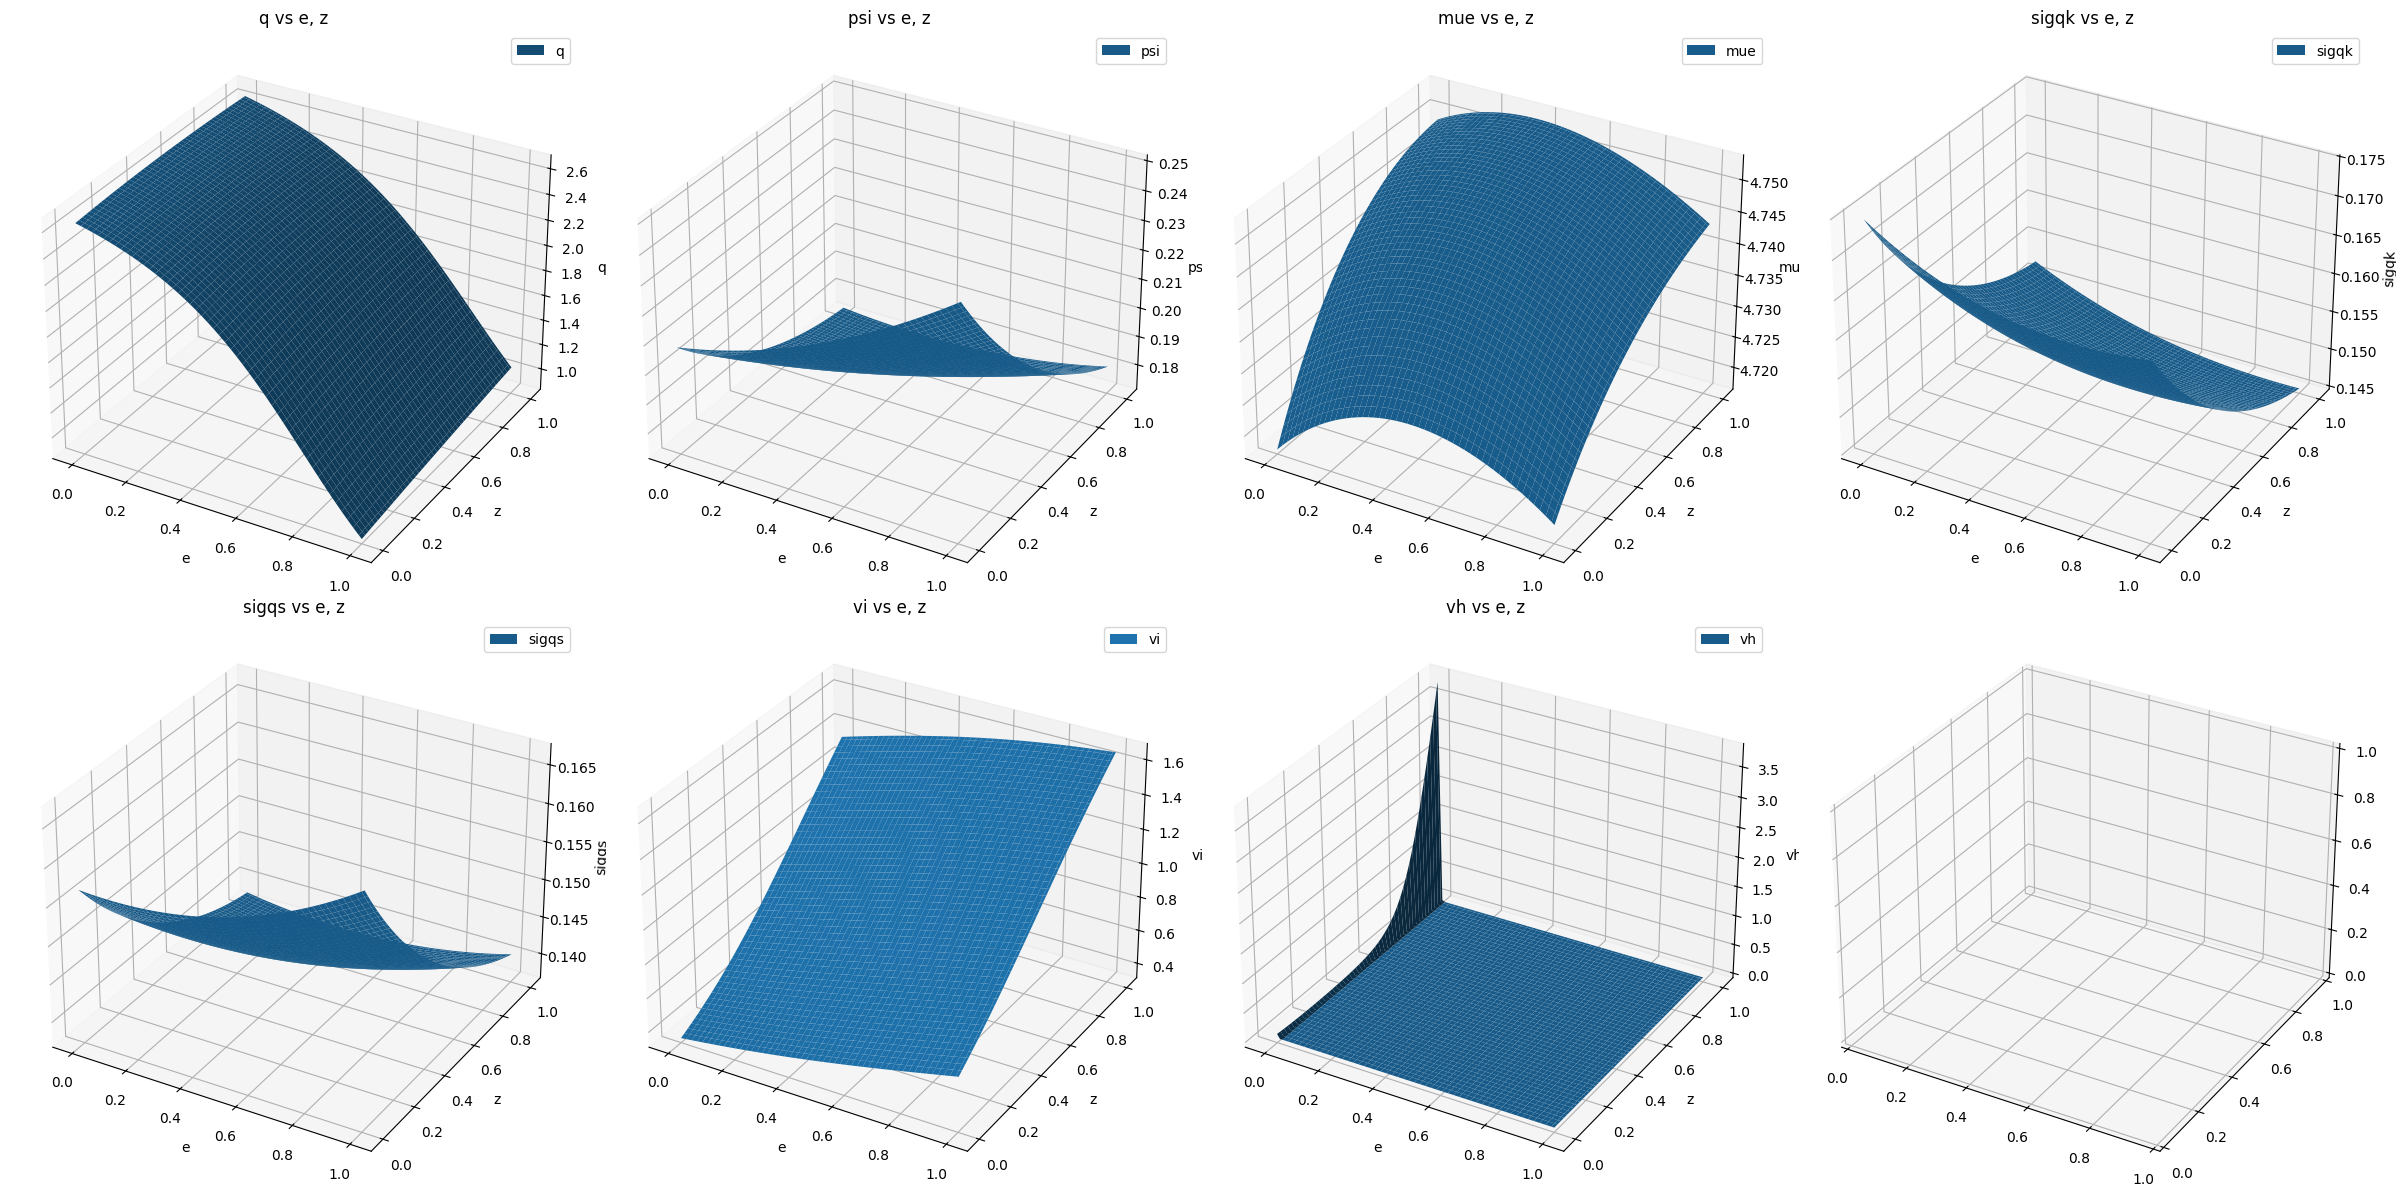

In [4]:
fig, ax = plt.subplots(2, 4, figsize=(24, 12), subplot_kw={"projection": "3d"})
# "q", "psi", "mue", "sigqk", "sigqs"
pde_model.endog_vars["q"].plot("q", {"e": [0, 1], "z": [0, 1]}, ax=ax[0][0])
pde_model.endog_vars["psi"].plot("psi", {"e": [0, 1], "z": [0, 1]}, ax=ax[0][1])
pde_model.endog_vars["mue"].plot("mue", {"e": [0, 1], "z": [0, 1]}, ax=ax[0][2])
pde_model.endog_vars["sigqk"].plot("sigqk", {"e": [0, 1], "z": [0, 1]}, ax=ax[0][3])
pde_model.endog_vars["sigqs"].plot("sigqs", {"e": [0, 1], "z": [0, 1]}, ax=ax[1][0])
pde_model.agents["vi"].plot("vi", {"e": [0, 1], "z": [0, 1]}, ax=ax[1][1])
pde_model.agents["vh"].plot("vh", {"e": [0, 1], "z": [0, 1]}, ax=ax[1][2])
plt.tight_layout()
plt.show()